# RICH AI Data Generation Process

**Purpose**: The purpose of this notebook is to demonstrate the data generation process for a single particle decay event as recorded by the RICH detector.

In [1]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Part 1: Reading in the data

- Currently, we are working with the 2018 dataset, which is split into three folders: `A`, `B`, and `C`.
- The data is saved in `HDF5` format, and each subset of data contains:

| Item             | Explanation                                                                   |
|------------------|-------------------------------------------------------------------------------|
| **Events**       | Event data on each particle decay event.                                      |
| **Hits**         | Hits data on each particle decay event.                                       |
| **Hits mapping** | Used to determine how to index the hits array to find the hits for one event. |

In [2]:
# data folder, data set, individual data file
data_folder = "/data/bvelghe/capstone2022/"
data_set = "A/"
file_path = "Run008548.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01.h5"

# read in 
f = h5py.File(os.path.join(data_folder, data_set, file_path))
f.keys()

<KeysViewHDF5 ['Events', 'HitMapping', 'Hits']>

In [3]:
events=f['Events']        # event data
hits=f['Hits']            # pm hit data for each hit
hit_map=f['HitMapping']   # maps range of hits for each event

## 1.1 Event data

- This section shows how to extract the features from the `Events` data in an `HDF5` file.
- We use event `0` here and throughout the notebook for demonstration purposes.

In [4]:
event = 5                       # first event
features = events.dtype.names   # features that each event has

In [5]:
print(f"Features for event: {event}")
for feat, value in zip(features, events[event]):
    print(f"{feat}: {value}")

Features for event: 5
run_id: 8548
burst_id: 1095
event_id: 138093
track_id: 0
track_momentum: 31.708349227905273
chod_time: 18.395217895507812
ring_radius: 182.3874969482422
ring_centre_pos: [-188.92627 -106.85196]
ring_likelihood: [5.3751084e-04 1.0000000e+00 4.0270428e-05]


## 1.2 PM signal data

- This section shows how to extract the PM signal data from the `Hits` data in an `HDF5` file.
- To do so, you also need the `HitMapping` data
- We index the `Hits` data as `Hits[HitsMapping[n]:HitsMapping[n+1]]` for event `n` to get the relevant data

In [6]:
# pm information for each hit
pm_info = hits.dtype.names
pm_info

('disk_id', 'pmt_id', 'supercell_id', 'updowndisk_id', 'hit_time')

In [7]:
# hitmap[n] to hitmap[n+1] is the indexing for hits, where n = event #
event_pm_info = hits[hit_map[event]:hit_map[event+1]]
event_pm_info

array([(1, 2, 58, 1, 18.422483), (1, 3, 10, 1, 18.47081 ),
       (1, 0, 34, 1, 18.438042), (1, 5, 45, 1, 18.583841),
       (1, 1, 44, 1, 18.420412), (1, 7, 18, 0, 18.372456),
       (1, 2, 20, 0, 18.725224), (1, 1, 16, 0, 18.333954),
       (1, 4, 26, 1, 17.789742), (1, 0, 58, 1, 18.490704),
       (1, 0, 26, 1, 18.04563 ), (1, 0, 18, 0, 18.92651 ),
       (1, 0, 20, 0, 19.10969 ), (1, 0, 16, 0, 18.183039),
       (1, 0, 10, 1, 18.22806 ), (1, 0, 34, 1, 18.426704),
       (1, 0, 44, 1, 18.671635), (1, 0, 45, 1, 18.35449 )],
      dtype=[('disk_id', '<i4'), ('pmt_id', '<i4'), ('supercell_id', '<i4'), ('updowndisk_id', '<i4'), ('hit_time', '<f4')])

In [8]:
# this is how many hits event 1 recorded, it will be variable for each event
print(f"# of hits for event {event+1}: {len(event_pm_info)}")

# of hits for event 6: 18


In [9]:
# info for pm hit 1/22 for event 1
print(f"PM info for event: {event}")
for info, value in zip(pm_info, event_pm_info[0]):
    print(f"{info}: {value}")

PM info for event: 5
disk_id: 1
pmt_id: 2
supercell_id: 58
updowndisk_id: 1
hit_time: 18.422483444213867


## 1.3 Mapping PM signals to $(x, y)$ positions

- The PM position map file is saved as `rich_pmt_positions.dat` in the `RICHPID` repo in the `tools` folder.
- Bob has provided a tool to parse this file to `npy` format.  
- To get this file one needs to run: `python conf_parser.py rich_pmt_positions.dat rich_pmt_positions.npy` in the `RICHPID/tools/` directory.
- We will see that there are 1,952 PM signals with $(x, y)$ locations accross two mirrors.
- We will use a function provided by Bob to help index the position map to extract the hit data that we need for each event.

In [10]:
# this is our full map of (x, y) locations that the light hits
position_map = np.load("/home/nico/RICHPID/tools/rich_pmt_positions.npy")
position_map.shape

(1952, 3)

In [11]:
# this is the first PM in the map
coord = position_map[1]

# pm location (x, y, mirror)
print("First pm in position map")
print(f"x:\t {coord[0]}")
print(f"y:\t {coord[1]}")
print(f"mirror:\t {coord[2]}")

First pm in position map
x:	 -243.0
y:	 93.52999877929688
mirror:	 0.0


In [12]:
# We need this function provided by Bob to map the hits from our PM info for each event.

def compute_seq_id(disk_id, up_dw_id, sc_id, pm_id, or_id=0):
    """Compute the RICH PMT sequence ID"""
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return seq_id

In [13]:
# this is the pm info for the first hit for the first event
single_hit_pm_info = event_pm_info[0]

# this computes which value in the pm position map the hit occured at
pm_map_location = compute_seq_id(
    disk_id=single_hit_pm_info["disk_id"],
    up_dw_id=single_hit_pm_info["updowndisk_id"],
    sc_id=single_hit_pm_info["supercell_id"],
    pm_id=single_hit_pm_info["pmt_id"],
)

print(f"This hit occured at idx {pm_map_location} in the position map")

This hit occured at idx 1930 in the position map


In [14]:
# therefore the (x, y, mirror) information for this hit is
position_map[pm_map_location]

array([ -54., -265.,    1.], dtype=float32)

### 1.3.1 Getting all hit data for one event

- Here we simple use a `for` loop to get all the hit data for a single event.

In [15]:
hits = []

for pm_info in event_pm_info:
    pm_idx = (
        compute_seq_id(
            disk_id=pm_info["disk_id"],
            up_dw_id=pm_info["updowndisk_id"],
            sc_id=pm_info["supercell_id"],
            pm_id=pm_info["pmt_id"]
        )
    )
    
    hits.append(position_map[pm_idx])
    
hits = np.array(np.array(hits))

# these are all the (x, y, mirror) locations for first first event
hits

array([[ -54.  , -265.  ,    1.  ],
       [ 189.  ,  -93.53,    1.  ],
       [ 162.  , -202.65,    1.  ],
       [ 153.  , -218.24,    1.  ],
       [ 126.  , -233.83,    1.  ],
       [  54.  ,   77.94,    1.  ],
       [ 144.  ,   15.59,    1.  ],
       [ -54.  ,   77.94,    1.  ],
       [-171.  ,  -62.35,    1.  ],
       [ -90.  , -265.  ,    1.  ],
       [-198.  ,  -77.94,    1.  ],
       [  18.  ,   46.77,    1.  ],
       [ 108.  ,   15.59,    1.  ],
       [ -72.  ,   77.94,    1.  ],
       [ 180.  , -109.12,    1.  ],
       [ 162.  , -202.65,    1.  ],
       [ 108.  , -233.83,    1.  ],
       [ 153.  , -249.42,    1.  ]], dtype=float32)

# Part 2: Some useful plots

<div class="alert alert-info" style="color:black">

## Questions

<ol type="1">
<li>Can you please remind us what the units of time are for the events?</li>
</ol>

</div>

## 2.1 Distribution of hit times
- Theoretically the hit times should show one single peak

''

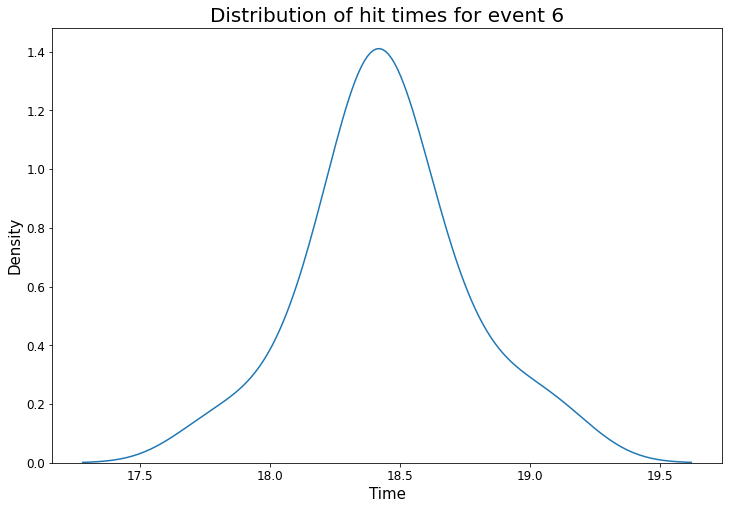

In [16]:
hit_times = []

# get all the hit time data for the first event
for pm_info in event_pm_info:
    hit_times.append(pm_info["hit_time"])

plt.figure(figsize=(12, 8))
sns.kdeplot(hit_times)
plt.title(f"Distribution of hit times for event {event+1}", fontsize=20)
plt.xlabel("Time", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
;

- For this event, we can see below that the first two hits are very far away in time from the remaining hits, and are therefore noise.  
- Our ML algorithm will need to deal with this noise.  We can also identify this based on `chod_time`, since we want our hit times to be close to the `chod_time`.

In [17]:
sorted(hit_times)

[17.789742,
 18.04563,
 18.183039,
 18.22806,
 18.333954,
 18.35449,
 18.372456,
 18.420412,
 18.422483,
 18.426704,
 18.438042,
 18.47081,
 18.490704,
 18.583841,
 18.671635,
 18.725224,
 18.92651,
 19.10969]

## 2.2 CHOD time vs. Event Time
- We want event times to be close to CHOD time.

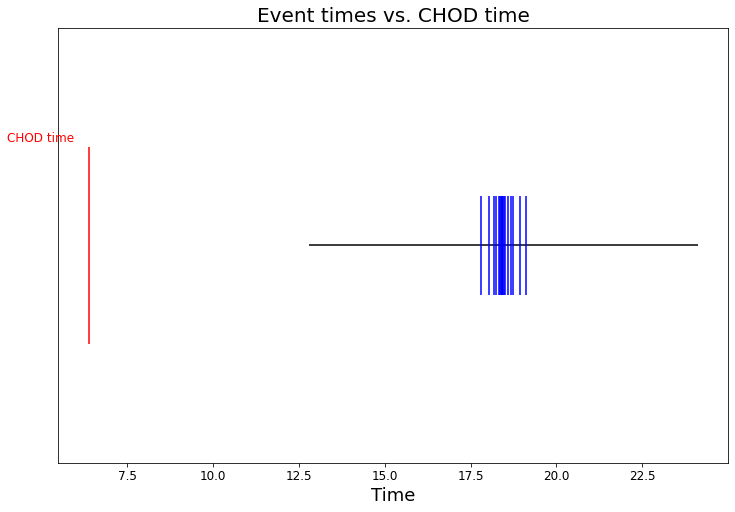

In [18]:
chod_time = events["chod_time"][0]

plt.figure(figsize=(12, 8))
plt.hlines(1,min(hit_times)-5,max(hit_times)+5, colors="black")  # Draw a horizontal line
plt.eventplot(hit_times, orientation='horizontal', colors='b')
plt.eventplot([chod_time], orientation='horizontal', colors='red', linelengths=2)
plt.text(4, 2.05, "CHOD time", color="red", fontsize=12)
plt.title("Event times vs. CHOD time", fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks([])
plt.show()

## 2.3 Ring plot

- Below we plot the pm array and the hits for the first event

In [19]:
# plotting function from Bob that plots the PMT array
def draw_pmt_pos(ax,pmt_pos):
    """
        Add circle patches corresponding to the PMT position to the Axes object ax
    """
    for i in pmt_pos:
        if i[2] == 0: # 0: Jura / 1: Salève, PMT disks are identical, we can pick either one. [TODO: CHECK!]
            ax.add_patch(plt.Circle((i[0],i[1]),1.0, color='black'))
    return ax

In [20]:
radius = events[event]['ring_radius']
centre = events[event]['ring_centre_pos']

print(radius)
print(centre)

182.3875
[-188.92627 -106.85196]


''

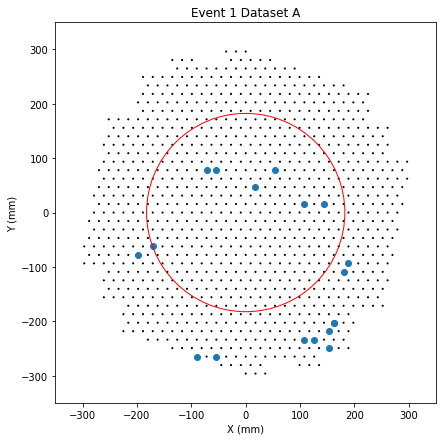

In [21]:
fig = plt.figure(figsize=(7, 7))
ax = fig.subplots()
ax.set_aspect('equal')
ax.set_xlim(-350,350) # mm
ax.set_ylim(-350,350) # mm
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_title(f'Event 1 Dataset A')

draw_pmt_pos(ax, position_map)
plt.scatter(hits[:, 0], hits[:, 1])
ax.add_artist(plt.Circle((0, 0), radius, fill=False,color="red"))
;

<div class="alert alert-info" style="color:black">

## Questions

<ol type="1">
<li>To overlay the circle properly, we had to plot the centre of the circle at $0, 0$ rather than the centre data as provided in the `HDF5` data.  We were curious as to why this was?</li>
</ol>

</div>

# Part 3: Combining all features

- We will need to combine all of the features that we have into a format that is readable by a machine learning model

<div class="alert alert-warning">

Key challenges:
    
1. The numbers of hits for each event will be variable, so the number of $(x, y)$ postions will be variable in length for each event.
2. The same logic above applies for hit times.
3. Track momentum and ring centre are biased by the sampling process, we will need to deal with this in modelling.
    
</div>

## 3.1: List of all raw features

| Name                  | Description                           | Notes                                                    | Located in                                                           |
|-----------------------|---------------------------------------|----------------------------------------------------------|----------------------------------------------------------------------|
| `run_id`              | The experiment run                    | Metadata                                                 | `HDF5["Events"]`                                                     |
| `burst_id`            | The particle burst                    | Metadata                                                 | `HDF5["Events"]`                                                     |
| `track_id`            | The particle track                    | Metadata                                                 | `HDF5["Events"]`                                                     |
| `track_momentum`      | Particle momentum                     | Single value                                             | `HDF5["Events"]`                                                     |
| `chod_time`           | Time recorded by CHOD detector        | Single value                                             | `HDF5["Events"]`                                                     |
| `ring_radius`         | Radius of fitted circle               | Single value                                             | `HDF5["Events"]`                                                     |
| `ring_centre_pos`     | Centre of fitted circle               | Array of two values: [x, y]                              | `HDF5["Events"]`                                                     |
| `ring_liklihood`      | Liklihood of three particles          | Array of three values: [particle1, particle2, particle3] | `HDF5["Events"]`                                                     |
| `disk_id`             | Used to locate hits with position map | Single value, input to `compute_seq_id`                  | `HDF5["Hits"]` indexed by `HDF5["HitMapping"]`                       |
| `pmt_id`              | Used to locate hits                   | Single value, input to `compute_seq_id`                  | `HDF5["Hits"]` indexed by `HDF5["HitMapping"]`                       |
| `supercell_id`        | Used to locate hits                   | Single value, input to `compute_seq_id`                  | `HDF5["Hits"]` indexed by `HDF5["HitMapping"]`                       |
| `updowndisk_id`       | Used to locate hits                   | Single value, input to `compute_seq_id`                  | `HDF5["Hits"]` indexed by `HDF5["HitMapping"]`                       |
| `hit_time`            | Time of each hit                      | Single value, but variable length for each event!        | `HDF5["Hits"]` indexed by `HDF5["HitMapping"]`                       |
| `hits (x, y, mirror)` | Actual coordinates and mirror hit     | Variable length for each event!                          | Get from `rich_pmt_positions.npy` with indices from `compute_seq_id` |

In [22]:
event = 0

## 3.2 Data from `HDF5["Events"]`

- This is just re-reading in the `Events` data for event 1 into a dictionary.

In [23]:
event_features = {k:v for k, v in zip(f['Events'].dtype.names, f['Events'][event])}

In [24]:
event_features

{'run_id': 8548,
 'burst_id': 1095,
 'event_id': 11551,
 'track_id': 0,
 'track_momentum': 39.102062,
 'chod_time': 6.377106,
 'ring_radius': 184.68147,
 'ring_centre_pos': array([-196.52412 ,  -16.790398], dtype=float32),
 'ring_likelihood': array([5.2108949e-01, 1.0000000e+00, 3.3442233e-05], dtype=float32)}

## 3.3 Hit data from `HDF5["Hits"]`, `HDF5["HitMapping"]`, and `rich_pmt_positions.npy`

- Here we re-read in the `Hits` data for event 1 into a dictionary.

In [25]:
position_map = np.load("/home/nico/RICHPID/tools/rich_pmt_positions.npy")
position_map.shape

(1952, 3)

In [26]:
hit_coords = []
hit_data = f['Hits'][f['HitMapping'][event]:f['HitMapping'][event+1]]
hit_times = hit_data["hit_time"]

# generate all hits coordinates for this event
for hit in hit_data:
    pm_idx = (
        compute_seq_id(
            disk_id=hit["disk_id"],
            up_dw_id=hit["updowndisk_id"],
            sc_id=hit["supercell_id"],
            pm_id=hit["pmt_id"]
        )
    )
    
    hit_coords.append(position_map[pm_idx])

hit_coords = np.array(hit_coords)

# combine coordinates with times
hit_coords_times = np.c_[hit_coords, hit_times]

```
array([[-171.       ,  -93.53     ,    1.       ,    6.4918146],
       [   0.       , -171.47     ,    1.       ,    6.334047 ],
       [ -27.       , -187.06     ,    1.       ,    6.0296416],  HIT TWICE
       [-153.       ,   93.53     ,    1.       ,    6.2478   ],
       [-162.       ,   77.94     ,    1.       ,    6.4438033],
       [-171.       ,   62.35     ,    1.       ,    6.271224 ],  HIT TWICE
       [ -72.       ,  171.47     ,    1.       ,  -28.139177 ],
       [ 189.       ,  -31.18     ,    1.       ,    6.3303947],
       [ 180.       ,   46.77     ,    1.       ,    6.297724 ],
       [ 180.       ,   15.59     ,    1.       ,    6.168077 ],
       [ 180.       ,  -46.77     ,    1.       ,    6.178306 ],
       [ 162.       ,   77.94     ,    1.       ,    6.3656635],
       [-171.       ,  -62.35     ,    1.       ,    7.366777 ],
       [-198.       ,  -77.94     ,    1.       ,    7.8246713],
       [-207.       , -124.71     ,    1.       ,    7.230756 ],
       [-108.       ,  140.3      ,    1.       ,  -27.836351 ],
       [ 189.       ,  -62.35     ,    1.       ,    6.2184596],
       [ 162.       ,   46.77     ,    1.       ,    5.7575994],
       [ 153.       ,    0.       ,    1.       ,    6.3124247],
       [ 144.       ,  -46.77     ,    1.       ,    6.40539  ],
       [-171.       ,   62.35     ,    1.       ,    5.7096343],  HIT TWICE
       [ -27.       , -187.06     ,    1.       ,    5.6795297]], HIT TWICE
```

<div class="alert alert-info" style="color:black">

## Questions

<ol type="1">
<li>We noted that some PM signals are hit by light twice in the same event.  For example, there are two PM signals from $(-27, -287.06)$ and $(-171, 62.35)$.  Is this just noise from the sensitivity of the sensor?</li>
<li>Is there a significance to a PM signal being generated twice for the same signal for an event?  Or do we just care in a boolean sense of whether or not light triggered the signal?</li>
<li>Does the mirror dimension have significance?  I.e. does it matter if the light hits mirror 0 or mirror 1?</li>
</ol>

</div>

## 3.2 Hit locations

- As noted, we will need to deal with the variable length of hits for each event to make it easier for our PyTorch dataloader
- Here we brainstorm two potential ways to deal with this.

### 3.2.1 Option 1: Dictionary mapper

- The first option would be to create a unique dictionary mapper that is able to map from `PM Signal -> Hit`
- Since we have 1,952 PM signals in the array, there would be 1,952 keys in our dictionary, and each event would have a single dictionary
- The keys would be in the format `(x, y, mirror)`
- In terms of the values in the dictionary mapper there a few options here:
    - Boolean value of whether or not the PM signal was triggered by light
    - Counter of how many times the PM signal was triggered if count matters (based on previous question)
    - Most recent hit time that the PM signal was triggered

In [27]:
hit_dict = {tuple(k):0 for k in position_map}

In [28]:
len(position_map) == len(hit_dict)

True

In [29]:
hit_dict

{(-261.0, 93.53, 0.0): 0,
 (-243.0, 93.53, 0.0): 0,
 (-225.0, 93.53, 0.0): 0,
 (-252.0, 109.12, 0.0): 0,
 (-234.0, 109.12, 0.0): 0,
 (-261.0, 124.71, 0.0): 0,
 (-243.0, 124.71, 0.0): 0,
 (-225.0, 124.71, 0.0): 0,
 (-216.0, 77.94, 0.0): 0,
 (-198.0, 77.94, 0.0): 0,
 (-180.0, 77.94, 0.0): 0,
 (-207.0, 93.53, 0.0): 0,
 (-189.0, 93.53, 0.0): 0,
 (-216.0, 109.12, 0.0): 0,
 (-198.0, 109.12, 0.0): 0,
 (-180.0, 109.12, 0.0): 0,
 (-171.0, 62.35, 0.0): 0,
 (-153.0, 62.35, 0.0): 0,
 (-135.0, 62.35, 0.0): 0,
 (-162.0, 77.94, 0.0): 0,
 (-144.0, 77.94, 0.0): 0,
 (-171.0, 93.53, 0.0): 0,
 (-153.0, 93.53, 0.0): 0,
 (-135.0, 93.53, 0.0): 0,
 (-126.0, 46.77, 0.0): 0,
 (-108.0, 46.77, 0.0): 0,
 (-90.0, 46.77, 0.0): 0,
 (-117.0, 62.35, 0.0): 0,
 (-99.0, 62.35, 0.0): 0,
 (-126.0, 77.94, 0.0): 0,
 (-108.0, 77.94, 0.0): 0,
 (-90.0, 77.94, 0.0): 0,
 (-81.0, 31.18, 0.0): 0,
 (-63.0, 31.18, 0.0): 0,
 (-45.0, 31.18, 0.0): 0,
 (-72.0, 46.77, 0.0): 0,
 (-54.0, 46.77, 0.0): 0,
 (-81.0, 62.35, 0.0): 0,
 (-63.0, 62.3

In [30]:
for coords in hit_coords:
    hit_dict[tuple(coords)] += 1

In [31]:
for coord, hit in hit_dict.items():
    if hit > 0:
        print(f"PMT: {coord}  \t  hits: {hit}")

PMT: (-171.0, 62.35, 1.0)  	  hits: 2
PMT: (-162.0, 77.94, 1.0)  	  hits: 1
PMT: (-153.0, 93.53, 1.0)  	  hits: 1
PMT: (144.0, -46.77, 1.0)  	  hits: 1
PMT: (180.0, -46.77, 1.0)  	  hits: 1
PMT: (189.0, -62.35, 1.0)  	  hits: 1
PMT: (189.0, -31.18, 1.0)  	  hits: 1
PMT: (153.0, 0.0, 1.0)  	  hits: 1
PMT: (180.0, 15.59, 1.0)  	  hits: 1
PMT: (-108.0, 140.3, 1.0)  	  hits: 1
PMT: (-72.0, 171.47, 1.0)  	  hits: 1
PMT: (162.0, 46.77, 1.0)  	  hits: 1
PMT: (180.0, 46.77, 1.0)  	  hits: 1
PMT: (162.0, 77.94, 1.0)  	  hits: 1
PMT: (-198.0, -77.94, 1.0)  	  hits: 1
PMT: (-171.0, -62.35, 1.0)  	  hits: 1
PMT: (-207.0, -124.71, 1.0)  	  hits: 1
PMT: (-171.0, -93.53, 1.0)  	  hits: 1
PMT: (-27.0, -187.06, 1.0)  	  hits: 2
PMT: (0.0, -171.47, 1.0)  	  hits: 1


### 3.2.2 Option 2: 2D array of PM signals

- The second option would be to create a 2D array of the PM signals
- To do this, we would use the unique `x` coordinates of our PM signals, and the unique `y` coordinates, and the create a 2D grid of zeros based on this.
- We would then fill the grid with a `1` is the PM signal at location `(x, y)` in the grid was hit by light.
- Note that since the PM array itself is a hexagon, there would be some locations in this 2D array (corners) that were always zero, since these PM signals would not actually exist.

In [32]:
# this just prints the smallest and largest (x, y) coordinates
print(f"Smallest (x, y): ({min(position_map[:, :1])[0]}, {min(position_map[:, 1:2])[0]})")
print(f"Largest (x, y): ({max(position_map[:, :1])[0]}, {max(position_map[:, 1:2])[0]})")

Smallest (x, y): (-297.0, -296.17999267578125)
Largest (x, y): (297.0, 296.17999267578125)


In [33]:
x_coords = set(position_map[:, :1].flatten())    # all the unique x coordinates
y_coords = set(position_map[:, 1:2].flatten())   # all the unique y coordinates

In [34]:
print(f"The 2D array shape will be {len(x_coords)} x {len(y_coords)}")

The 2D array shape will be 67 x 39


In [35]:
# now this is an array of all the pm discs with boolean hit/not hit values
pm_hit_locations = pd.DataFrame(
    np.zeros((len(y_coords),len(x_coords))),
    index=y_coords,
    columns=x_coords
)
pm_hit_locations = pm_hit_locations.sort_index().sort_index(axis=1)
pm_hit_locations

,-297.0,-288.0,-279.0,-270.0,-261.0,-252.0,-243.0,-234.0,-225.0,-216.0,...,216.0,225.0,234.0,243.0,252.0,261.0,270.0,279.0,288.0,297.0
-296.179993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-280.589996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-265.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-249.419998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-233.830002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-218.240005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-202.649994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-187.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-171.470001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-155.880005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# add 1s to the grid where the hits occured
for hit in hit_coords:
    pm_hit_locations.at[hit[1], hit[0]] += 1

In [37]:
pm_hit_locations.sum().sum() == len(hit_coords)

True

<div class="alert alert-info" style="color:black">

## Questions

<ol type="1">
<li>What are your thoughts on these two approaches?</li>
</ol>

</div>

## 3.3 Hit times (In progress, depends on conclusions in 2.2)

- We need to deal with the variable number of hits, and hit times, for each event.
- Since we have 1,952 PM discs that can be hit by light, there are a max number of 1,952 hits that can occur for any event
- Therefore we could pad the `hit_times` so that the shape is `(1952, 1)` where the value in the vector is the time that that PM disc got hit
- May be tricky though if discs are getting hit twice...

In [38]:
hit_features = {}
total_pm_discs = position_map.shape[0]

# padded number of hit times
hit_times = np.pad(
    array=hit_times,
    pad_width=(0, total_pm_discs - hit_times.shape[0])
)

hit_features["hit_times"] = hit_times

print(hit_times)
print(hit_times.shape)

[6.4918146 6.334047  6.0296416 ... 0.        0.        0.       ]
(1952,)
